## Transient Simulations 
*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import time


from pyDOE import *
import random
#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput/transientDrawdown"
modws = "D:\\mfoutput\\transientSeasons"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y


#ztop = 100
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties - These get overwritten in the run code cell
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 


## Recharge
rech=5e-5  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


print(ztop[25])

[100.   99.   98.   97.   96.   95.   94.   93.   92.   91.   90.   89.
  88.   87.   86.   85.   84.   83.   82.   81.   80.   79.   78.   77.
  76.   75.9  75.8  75.7  75.6  75.5  75.4  75.3  75.2  75.1  75.   74.9
  74.8  74.7  74.6  74.5  74.4  74.3  74.2  74.1  74.   73.9  73.8  73.7
  73.6  73.5]


In [3]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 10
#sim_years = 2
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array - actually we are doing it every 6 days to save computation time
nstp=perlen/6 # Slghtly less than weekly 
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)

#Irrigation well

#Aqua Seca Well well
pumping = -2500 #m3/day 
SteadyPump = -2000 #might want to increase the seasonal pumping
well_row =   19 #12
well_col =   32 #14
well_loc = (2,well_row, well_col)
well = [2,well_row, well_col, pumping] 

#Seasonal pumpng stress periods
wel_spd =  {0: [2,well_row, well_col, 0]}
well_val = np.tile([1,0],sim_years+1)
for p in range(1, nper):   
    #pumping = 0
    wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]]
print(wel_spd)

#Steady Pumping rate 
# wel_spdst =  {0: [2,well_row, well_col, 0]}
# well_val = np.tile([1,1],sim_years+1)
# for p in range(1, nper):   
#     #pumping = 0
#     wel_spdst[p] =  [2,well_row, well_col, SteadyPump*well_val[p]]
    
# print(wel_spdst)


Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180]
Number of Steps [ 1 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30]
{0: [2, 19, 32, 0], 1: [2, 19, 32, 0], 2: [2, 19, 32, -2500], 3: [2, 19, 32, 0], 4: [2, 19, 32, -2500], 5: [2, 19, 32, 0], 6: [2, 19, 32, -2500], 7: [2, 19, 32, 0], 8: [2, 19, 32, -2500], 9: [2, 19, 32, 0], 10: [2, 19, 32, -2500], 11: [2, 19, 32, 0], 12: [2, 19, 32, -2500], 13: [2, 19, 32, 0], 14: [2, 19, 32, -2500], 15: [2, 19, 32, 0], 16: [2, 19, 32, -2500], 17: [2, 19, 32, 0], 18: [2, 19, 32, -2500], 19: [2, 19, 32, 0], 20: [2, 19, 32, -2500]}


### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Made some changes to the thickness
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [5]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0

## Right Boundary condition
h_right = 68.5 #was 70

H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream with SFR2 Package

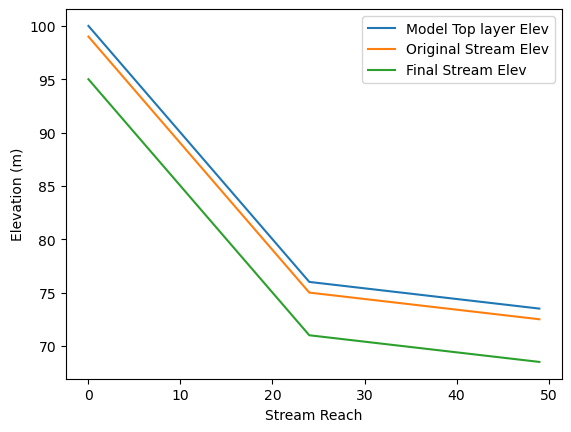

In [6]:
#SFR package inputs
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4')])

reach[:][:] = 0.0 # zero it out
#reach['k'][:] = 0 #testing
reach['i'][:] = ncol/2   #set it to the middle row
reach['j'][:] = [i for i in range(nrow)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx * 1.2 #using a moderate sinuosity of 1.2 from Rosgen 
reach['strtop'][:] = ztop[25]-5 #Sets the stream elevation to below the top of the top layer cells 
#print(ztop)

#Segment Data - 1 segment with 50 reaches
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype() #get the correct datatypes for the segments
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']

seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #Upstream width
seg_data['width2'] = 5 #downstream width
seg_data['icalc'] = 1 #Stream depth calculated every stress period - assumes wide rectangular channel - uses Manning's equation
seg_data['nseg'] = 1 #segment number
seg_data['roughch'] = 0.045 #Manning's n 
seg_data['flow'] = 100#initial inflow at first reach in segment
seg_data['hcond1'] = 0.0001 #K - also set in the run cell as it is one of the parameters that is varied
seg_data['hcond2'] = 0.0001 
seg_data['thickm1'] = 2  #Stream bed thickness
seg_data['thickm2'] = 2  
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
seg_data['etsw'] = 0  #Stream channel ET
seg_data['pptsw'] = 0 #Stream channel precip

segment_data = seg_data

nstrm = -len(reach)  # number of reaches - negative for transient!
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 86400  # constant for manning's equation, units of cms
dleak = 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0:[nss, 0, 0]}  # dataset 5 (see online guide) - first one must be equal to number of segments 

numtim =  1 #number of timesteps to compute for routing

for i in range(1,nper):
    dataset_5[i] = [0, 0, 0] #one for every stress period, first number must be less than number of segments (except first stress period) (for some reason)


irtflg = 1 #flag for routng with kinematic wave, if so desired, other params need to be set

# strbtm_elevs = np.linspace(ztop[25][25]-2,ztop[25][-1]-1,25)
# strtop_elevs = np.linspace(ztop[25][0]-10,ztop[25][24]-2,25)
# streamtest=np.zeros((50,))
# #streamtest = ztop[25].copy()
# streamtest[:25] = strtop_elevs
# streamtest[25:] = strbtm_elevs

plt.plot(ztop[25], label='Model Top layer Elev')
plt.plot(ztop[25]-1, label='Original Stream Elev')
#plt.plot(streamtest, label='Stream test')
plt.plot(reach['strtop'][:], label = 'Final Stream Elev')
plt.xlabel('Stream Reach')
plt.ylabel('Elevation (m)')
plt.legend()

In [7]:
#Output control - OC 

oc_spd = {}
for kper in range(0,nper):
    for kstp in range(0,nstp[kper]):
        #print(kstp)
        if (kstp+1) % 6 == 0: #writing only every 6th one now to save memory
            oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
            #print(kper,kstp,' write')
        else:
            oc_spd[(kper, kstp)] = []
           # print(kper,kstp,' skip')
            
#make sure to save the first one          
oc_spd[(0, 0)] = ['save head','save drawdown','save budget','print head','print budget']
#print(oc_spd)

## create packages and run model

In [8]:
#create model object

#load in the parameter sampling from text - so it's the same everytime
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test9.pkl')
print(len(well_head_df.index.values))
sampling = np.loadtxt("ModflowParams8-1000Test4.txt")

print(sampling[well_head_df.index.values].shape)

959
(959, 8)


In [21]:
n = len(sampling)#np.loadtxt('TransSamples.txt').astype('int')
error_list = []

members = well_head_df.index.values

#Using the same numbering as the steady state (so 9)
for i in members[436:]:
    t0 = time.time()
    #print(sampling[i])
    modelname = "ScenarioSfr1000SeasonsTest9_"+str(i)
    #modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(i)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady,perlen=perlen, nstp=nstp)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    Kh[:,:,:] = 5
    Kz[:,:,:] = 5 
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1]     
   #changed to 10 for start of restrictive layer
   
    #Specific Yield
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    #Setting up ET stress periods   
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
    
    ET_val=np.tile([1, 0],sim_years)
    ET_val=np.append(sampling[i][4]/2,ET_val) #add on steady state period at beginning with 1/2 the ET 
   
    ET = {} #ET Stress period dictionary
    for p in range(1,nper):    #loop over stress periods
        #print(ET_val[p])        
        ET[p]=ET_zone*ET_val[p] 
    
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)
    
    #No seasonality
    #evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)


    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]= sampling[i][3]
      
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

    #SFR2 
    seg_data['hcond1'] = seg_data['hcond2'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        #istcb1 = 81,
        istcb2=istcb2,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5,
        #unit_number=15,
        irtflg = irtflg,
        numtim = numtim,#number of timesteps to compute for routing
        flwtol = 0.00003*86400,
        transroute = True
    )
    sfr.assign_layers(adjust_botms=True, pad=1.0) #I haven't figure out yet why the Transient version has issues with the channel bottom - but this fixes it by offsetting by -1 if there is an issue
    #print(sfr.reach_data)
    
    #Well
    wel_spd =  {0: [2,well_row, well_col, 0]}
    well_val = np.tile([1,0],sim_years+1)
    for p in range(1, nper):   
        #pumping = 0
        wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]*sampling[i][7]]
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd) #Seasonal pumping

    #Steady Pumping rate 
#     wel_spdst =  {0: [2,well_row, well_col, 0]}
#     well_val = np.tile([1,1],sim_years+1)
#     for p in range(1, nper):   
#         #pumping = 0
#         wel_spdst[p] =  [2,well_row, well_col, SteadyPump*well_val[p]*sampling[i][7]]
        
#     wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spdst) #steady pumping lower rate

  
   # spd = {(-1, -1): [],
     #   (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97,
                               damp = 0.7
                              )

    #write the inputs
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=False, silent=True)
    
    t1 = time.time()
    tt = t1-t0
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file', i)
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))
     
    else:
        print("Simulation " + str(i) + " Terminated Normally. Time: " + str(tt))
        
#Remove the ones that did not terminate normally and save off the ones that did        
if len(error_list) > 0:
    #np.savetxt("ErrorSeasons_Sfr750.txt", error_list)
    np.savetxt("ErrorSeasons_Sfr1000Test9.txt", error_list)

    print(len(error_list), " models did not terminate normally.")
    #print(error_list[:,0])
    err = [16,32,52,53,60,64,65,74,76,79,89,95,96,102,108,113,115,146,147,159,163,165,168,175,185,189,219,227,228,230,232,236,258,260,270,274,284,285,286,287,292,298,302,305,207,308,311,312,317,320,324,333,335,344,347,369,373,383,386,396,400,414,421,433,438,439,440,452,459,463]
    error_list = np.asarray(error_list)
    n2 = np.setdiff1d(members, error_list[:,0].astype('int'))
    n3 = np.setdiff1d(n2, err)

else:
    n3 = members
    
for k,i in enumerate(n3):
    modelname = "ScenarioSfr1000SeasonsTest9_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    #Plot of all every reaches for every time step 
    #should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
    df['Stp']= 1
   # df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
    #use this one for the reduced reporting
    df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*5*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column

    df['simnum'] = i
    #group rows by change in Stp and grab the last Stress period 
    Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
    Stpdf.reset_index(drop=True, inplace = True)
   # print(Stpdf)
    if k == 0:
        savedf = Stpdf
    else:
        savedf = savedf.append(Stpdf) #apparently appending a dataframe is improper so this takes a minute

print(len(savedf))
savedf.to_csv('TransOutputStpSeasonsTest9.csv')

Simulation 466 Terminated Normally. Time: 38.28309369087219
Simulation 467 Terminated Normally. Time: 48.75853443145752
Simulation 468 Terminated Normally. Time: 51.38259983062744
Simulation 470 Terminated Normally. Time: 39.73505473136902
Simulation 471 Terminated Normally. Time: 39.50937366485596
Simulation 472 Terminated Normally. Time: 40.183586835861206
Simulation 473 Terminated Normally. Time: 50.90358233451843
Simulation 475 Terminated Normally. Time: 48.57169795036316
Simulation 476 Terminated Normally. Time: 42.53690266609192
Simulation 477 Terminated Normally. Time: 42.032843828201294
Simulation 478 Terminated Normally. Time: 47.16569399833679
Simulation 479 Terminated Normally. Time: 40.93749213218689
Simulation 480 Terminated Normally. Time: 41.408052921295166
Simulation 482 Terminated Normally. Time: 40.63661456108093
Simulation 483 Terminated Normally. Time: 43.09185481071472
Simulation 484 Terminated Normally. Time: 35.65503454208374
Simulation 485 Terminated Normally. T

MODFLOW did not terminate normally. Parameters saved to file 608
MODFLOW did not terminate normally. Parameters saved to file 609
Simulation 610 Terminated Normally. Time: 38.843284130096436
Simulation 611 Terminated Normally. Time: 46.259265422821045
Simulation 612 Terminated Normally. Time: 47.566814661026
Simulation 613 Terminated Normally. Time: 36.85148549079895
Simulation 614 Terminated Normally. Time: 35.07085919380188
MODFLOW did not terminate normally. Parameters saved to file 615
Simulation 616 Terminated Normally. Time: 39.7606155872345
Simulation 617 Terminated Normally. Time: 43.41183924674988
Simulation 618 Terminated Normally. Time: 46.29245066642761
Simulation 619 Terminated Normally. Time: 46.51380968093872
Simulation 620 Terminated Normally. Time: 41.16400766372681
Simulation 621 Terminated Normally. Time: 39.295241355895996
Simulation 622 Terminated Normally. Time: 39.793195486068726
Simulation 623 Terminated Normally. Time: 44.054340839385986
MODFLOW did not termina

Simulation 745 Terminated Normally. Time: 42.51027297973633
Simulation 746 Terminated Normally. Time: 39.91433143615723
Simulation 747 Terminated Normally. Time: 43.811400413513184
Simulation 748 Terminated Normally. Time: 39.99343657493591
Simulation 749 Terminated Normally. Time: 44.98575949668884
Simulation 750 Terminated Normally. Time: 39.650861501693726
Simulation 751 Terminated Normally. Time: 43.83743596076965
Simulation 752 Terminated Normally. Time: 39.86756181716919
MODFLOW did not terminate normally. Parameters saved to file 753
Simulation 754 Terminated Normally. Time: 40.197503328323364
Simulation 755 Terminated Normally. Time: 34.48638653755188
Simulation 756 Terminated Normally. Time: 49.3342719078064
Simulation 757 Terminated Normally. Time: 42.66478896141052
Simulation 758 Terminated Normally. Time: 43.6785089969635
Simulation 759 Terminated Normally. Time: 40.06017184257507
Simulation 760 Terminated Normally. Time: 46.25675010681152
Simulation 761 Terminated Normally

Simulation 881 Terminated Normally. Time: 39.528897762298584
Simulation 882 Terminated Normally. Time: 40.54689812660217
Simulation 883 Terminated Normally. Time: 38.33638024330139
MODFLOW did not terminate normally. Parameters saved to file 884
Simulation 885 Terminated Normally. Time: 42.78842306137085
Simulation 886 Terminated Normally. Time: 39.59716081619263
MODFLOW did not terminate normally. Parameters saved to file 887
Simulation 888 Terminated Normally. Time: 37.599568128585815
Simulation 889 Terminated Normally. Time: 40.31491446495056
Simulation 890 Terminated Normally. Time: 35.55200695991516
Simulation 891 Terminated Normally. Time: 40.178385496139526
Simulation 892 Terminated Normally. Time: 39.30682873725891
MODFLOW did not terminate normally. Parameters saved to file 893
Simulation 894 Terminated Normally. Time: 40.20629358291626
MODFLOW did not terminate normally. Parameters saved to file 895
Simulation 896 Terminated Normally. Time: 41.89698505401611
MODFLOW did not t

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 3105: character maps to <undefined>

## Looking at the SFR Output

In [ ]:
#error on 436
err=[16,32,52,53,60,64,65,74,76,79,89,95,96,102,108,113,115,146,147,159,163,165,168,175,,185,189,219,227,228,230,232,236,258,260,270,274,284,285,286,287,292,298,302,305,207,308,311,312,317,320,324,333,335,344,347,369,373,383,386,396,400,414,421,433]

[ 0  2  4  6  8 10]
[  31 1031 2031 3031 4031 5031]
0.8976985082753117  ft/s


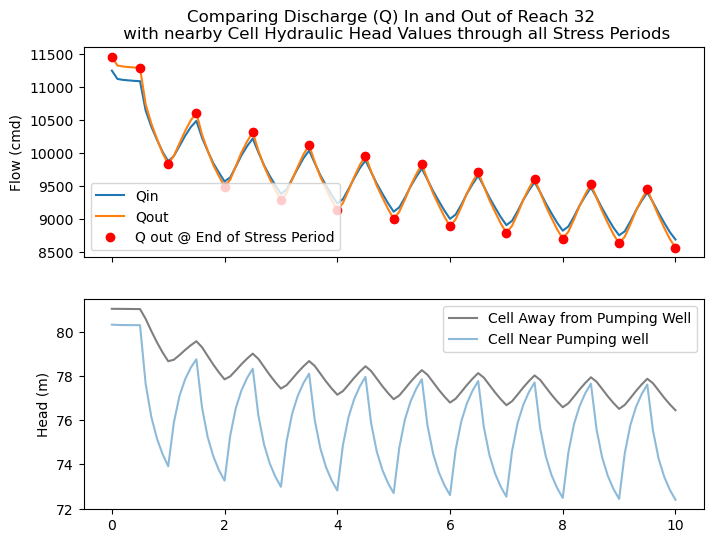

In [17]:
#Plotting out stream Q with head values across all time stepss
#modelname = "ScenarioSfr2500_Trans_1"
#np.loadtxt('TransSamples.txt').astype('int')
modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(0)
modelname = "ScenarioSfr1000SeasonsTest9_"+str(1)

sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
df = sfrout.get_dataframe()
rn =32
df.reset_index(drop = False, inplace = True) #FOr some reason the index seems to be off number wise so this helps
#display(df[df.reach == rn])

#Backing out the stress period from the rows
#should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
df['Stp']= 1
#df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*5*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last colum

#group rows by change in Stp and grab the last Stress period 
Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
#print(Stpdf.iloc[50])
#print(df.iloc[50])
fig, axs = plt.subplots(2,1,sharex = True,sharey=False)

inds = df.reach == 32 #grab indices for reach of interest
#print(df.reach[inds].astype(str))
#print(df.index)
df.loc[inds, ["Qin","Qout"]].plot(figsize = (8,6), ax = axs[0])
axs[0].set_ylabel("Flow (cmd)")
axs[0].set_xlabel("Stress Period End");
axs[0].plot(Stpdf[Stpdf.reach == 32].index,Stpdf[Stpdf.reach == 32].Qout,'or', label = 'Q out @ End of Stress Period')
axs[0].legend(loc='lower left')
ticklabels = np.arange(0,12,2)#[0,5,10,15,20]
xticks = np.arange(0,6000,1000)+31#[0,3031,6031,9031,12031]
print(ticklabels)
print(xticks)
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(ticklabels)
axs[0].title.set_text('Comparing Discharge (Q) In and Out of Reach 32 \n with nearby Cell Hydraulic Head Values through all Stress Periods')

#Add the Stressperiod dataframe to the plot (checking to make sure it's all correct) - we lose the nice curves but this is much less data
#Stpdf.loc[inds, ["Qout", "Qin"]].plot(figsize = (20,7), axs[0] = axs[0])


headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
head = headobj.get_ts([(0,15,32)]) #time series from obs well 
head[:,0] = ((head[:,0] - 10)/36)* 50* numtim + rn-1 #go from total time to the reach (50), reports every 36th time step now, times in the SFR file, times numtim (was 2, now 4)  if routing is on
#head[:,0] = ((head[:,0] - 10 ) / 6) * 50 *numtim +rn-1 #go from total time to the reach (50) period (6) times in the SFR file, times numtim (was 2, now 4)  if routing is on

#axs[1] = axs[0].twinx()
axs[1].plot(head[:,0],head[:,1],'k', label ='Cell Away from Pumping Well', alpha = 0.5)

headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
head = headobj.get_ts([(0,20,31)]) #time series from obs well next two stream and pumping well
head[:,0] = ((head[:,0] - 10)/36)* 50* numtim + rn-1 #go from total time to the reach (50), reports every 36th time step now, times in the SFR file, times numtim (was 2, now 4)  if routing is on
#head[:,0] = ((head[:,0] - 10 ) / 6) * 50 *numtim +rn-1 #go from total time to the reach (50) period (6) times in the SFR file, times numtim (was 2, now 4)  if routing is on

axs[1].plot(head[:,0],head[:,1], label ='Cell Near Pumping well', alpha = 0.5)
axs[1].set_ylabel('Head (m)')
axs[1].legend()
axs[1].set_xticks([], minor=True)
#print(df.loc[inds,["Qin","Qaquifer","Qout","Stp"]][df.Stp > 9])
Stpdf.reset_index(drop=True, inplace = True)
#display(Stpdf)
lastStp = Stpdf.iloc[231]
print((lastStp.Qout / (lastStp.width * lastStp.depth) / 86400) * 3.28, ' ft/s')

C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


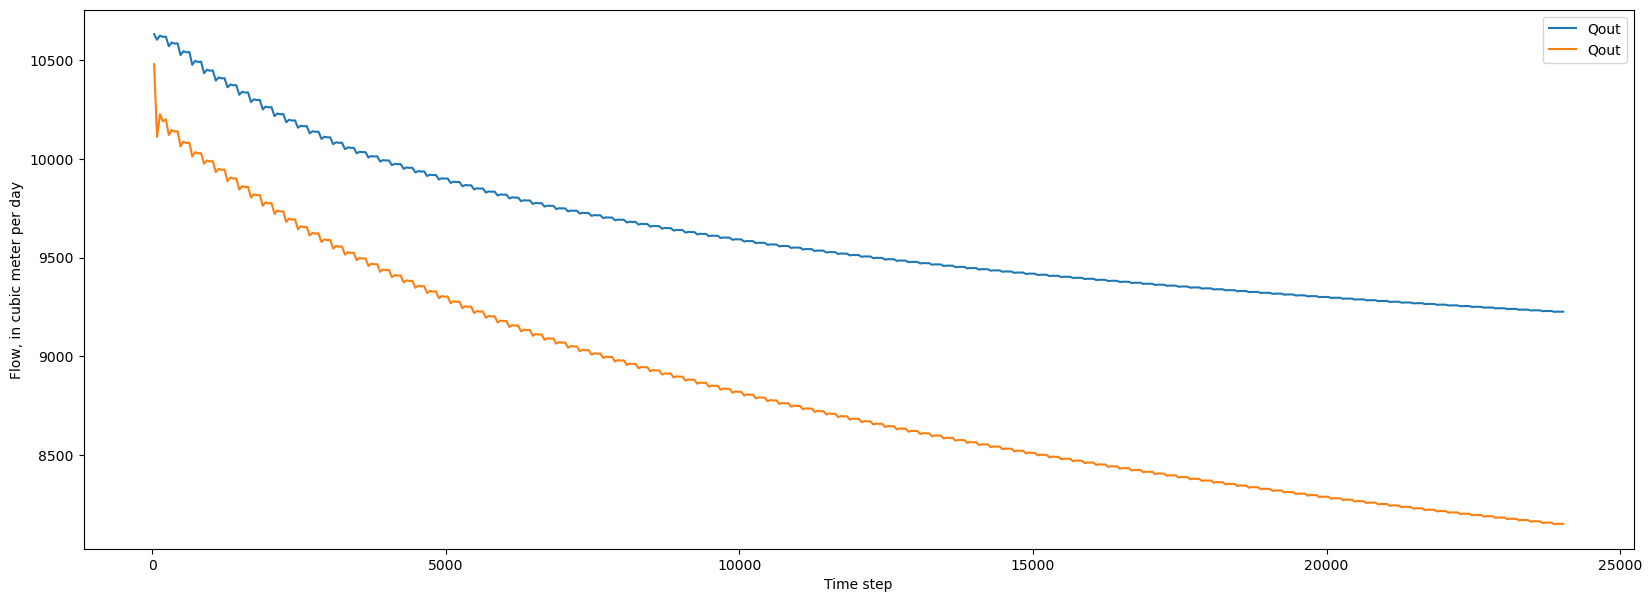

In [26]:
#Look at the variation in Q aquifer for the 5 random sampled simulations

for i in range(2):
    modelname = "ScenarioSfr1000SteadyPumpTest11_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    df.reset_index(drop = True, inplace = True)
     #grab indices for reach of interest
#print(df.reach[inds].astype(str))
    inds = df.reach == 32
    if i == 0:
        ax = df.loc[inds, ["Qout"]].plot(figsize = (20,7))
    else:
        df.loc[inds, ["Qout"]].plot(figsize = (20,7), ax =ax)
    
ax.set_ylabel("Flow, in cubic meter per day")
ax.set_xlabel("Time step");



(98., 71.5)


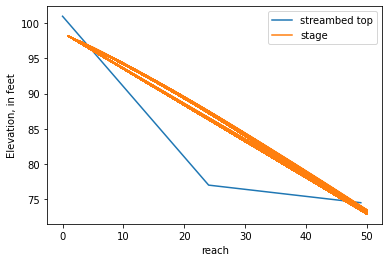

In [31]:
streambed_top = m.sfr.segment_data[0][m.sfr.segment_data[0].nseg == 1][["elevup", "elevdn"]][0]
print(streambed_top)


inds = df.segment == 1

fig, ax = plt.subplots()
plt.plot(np.arange(0,50), ztop[26], label="streambed top")
# ax = df.loc[inds, ['stage', 'model_top']].plot(ax=ax, x=df.reach[inds])
ax = df.loc[inds, ["reach", "stage"]].plot(ax=ax, x="reach")
ax.set_ylabel("Elevation, in feet")
plt.legend();

## Saving the output for each run 

In [16]:
#now in the bottom of the modflow run cell so no need to run this unless outside of that cell

error_list = np.loadtxt('ErrorSeasons_Sfr1000Test9.txt')
#print(error_list)
#sampling = np.loadtxt("ModflowParams7-750Test12.txt")
n = np.arange(0,len(sampling))
n = well_head_df.index.values

print(error_list[:,0])

n2 = np.setdiff1d(n, error_list[:,0].astype('int'))
err = [0,3,8,16,32,52,53,60,64,65,74,76,79,89,90,95,96,102,108,113,115,146,147,159,163,165,168,175,185,189,219,227,228,230,232,236,258,260,270,274,282,284,285,286,287,292,298,302,305,307,308,311,312,317,320,324,325,333,335,344,347,369,373,383,386,396,400,414,421,433,438,439,440,452,459,463]
error_list = np.asarray(error_list)
n3 = np.setdiff1d(n2, err)

for k,i in enumerate(n3):
    modelname = "ScenarioSfr1000SeasonsTest9_"+str(i)
   # print(modelname)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    #Plot of all every reaches for every time step 
    #should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
    df['Stp']= 1
    df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*5*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
    df['simnum'] = i
    #group rows by change in Stp and grab the last Stress period 
    Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
    Stpdf.reset_index(drop=True, inplace = True)
   # print(Stpdf)
    if k == 0:
        savedf = Stpdf
    else:
        savedf = savedf.append(Stpdf) #apparently appending a dataframe is improper so this takes a minute

print(len(savedf))
savedf.to_csv('TransOutputStpSeasonsTest9.csv')

[502. 510. 514. 517. 519. 525. 532. 533. 536. 550. 558. 568. 569. 570.
 571. 579. 592. 596. 597. 600. 608. 609. 615. 624. 625. 627. 634. 641.
 642. 652. 653. 657. 661. 663. 664. 671. 679. 689. 700. 706. 719. 729.
 743. 753. 762. 765. 770. 792. 793. 796. 797. 799. 806. 807. 814. 817.
 829. 855. 869. 874. 877. 884. 887. 893. 895. 897. 901. 923. 924. 929.
 931. 947. 955. 959. 962. 970. 985. 993. 995.]
848450


In [30]:
#Test 
newdf = pd.read_csv('TransOutputStpSeasonsTest9.csv')
display(newdf)

,Unnamed: 0,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,...,depth,width,Cond,gradient,kstpkper,k,i,j,Stp,simnum
0,0,1,26,1,1,1,100.00,0.00000,100.00,0.0,...,0.005213,5.0,0.0,0.000000,"(0, 0)",0,25,0,1,1
1,1,1,26,2,1,2,100.00,-0.20789,100.21,0.0,...,0.005217,5.0,974.0,-0.000107,"(0, 0)",0,25,1,1,1
2,2,1,26,3,1,3,100.21,-203.88000,304.08,0.0,...,0.007953,5.0,974.0,-0.104700,"(0, 0)",0,25,2,1,1
3,3,1,26,4,1,4,304.08,-325.58000,629.67,0.0,...,0.013140,5.0,974.0,-0.167100,"(0, 0)",0,25,3,1,1
4,4,1,26,5,1,5,629.67,-411.52000,1041.20,0.0,...,0.018630,5.0,974.0,-0.211300,"(0, 0)",0,25,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851245,1045,1,26,46,1,46,8332.90,-24.11500,8356.90,0.0,...,0.074120,5.0,764.5,-0.015770,"(0, 0)",0,25,45,21,999
851246,1046,1,26,47,1,47,8356.90,-4.93600,8361.80,0.0,...,0.074200,5.0,764.5,-0.003228,"(0, 0)",0,25,46,21,999
851247,1047,1,26,48,1,48,8361.80,21.82600,8340.00,0.0,...,0.074160,5.0,764.5,0.014280,"(0, 0)",0,25,47,21,999
851248,1048,1,26,49,1,49,8340.00,69.86800,8270.10,0.0,...,0.073910,5.0,764.5,0.045700,"(0, 0)",0,25,48,21,999


## Read SFR outputs from Steady State notebook

In [208]:
#sfr_outfile = os.path.join(..', 'data', 'sfr_examples')
sfrout = SfrFile(modwsmodelname+'.sfr.out')
df = sfrout.get_dataframe()
print(df.Qaquifer[47])

-2.4791


C:\Users\davem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\davem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


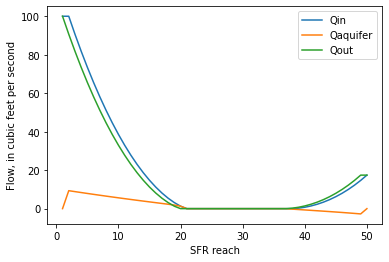

In [205]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach")
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("SFR reach");

## Plots to make sure heads are okie dokie

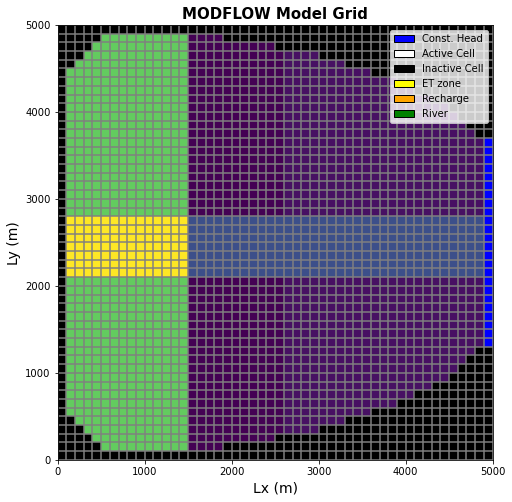

<Figure size 432x288 with 0 Axes>

In [59]:
#PLotting out the basin figure


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
# quadmesh = modelmap.plot_array(rech_zone_forced)
# quadmesh = modelmap.plot_array(Rip_zone)

#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc(ftype='RCH')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound)



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('MODFLOW Model Grid', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   # mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
plt.savefig('DomaingridNew.png')

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\map.py:1272: DeprecationWarning: ModelMap is deprecated and has been replaced by PlotMapView(). ModelMap will be removed in version 3.3.5; Calling PlotMapView()
  warnings.warn(err_msg, DeprecationWarning)


AttributeError: 'NoneType' object has no attribute 'parent'

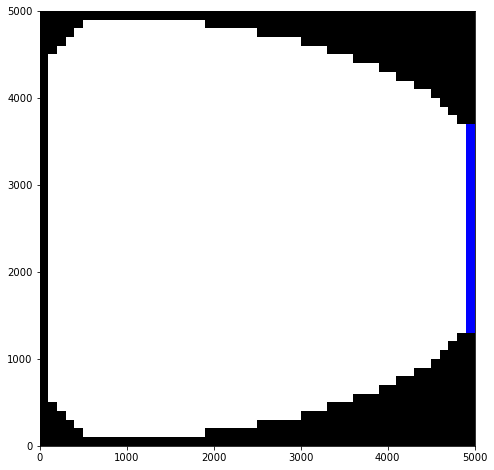

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
quadmesh = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc('SFR')
#quadmesh = modelmap.plot_bc('WEL')
linecollection = modelmap.plot_grid()

[      nan       nan       nan       nan       nan 171.81361 171.16365
 170.06374 168.69116 167.04881 165.89494 164.2788  162.2466  159.8222
 157.01859 153.84712 150.89365 148.29123 146.41052       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan]


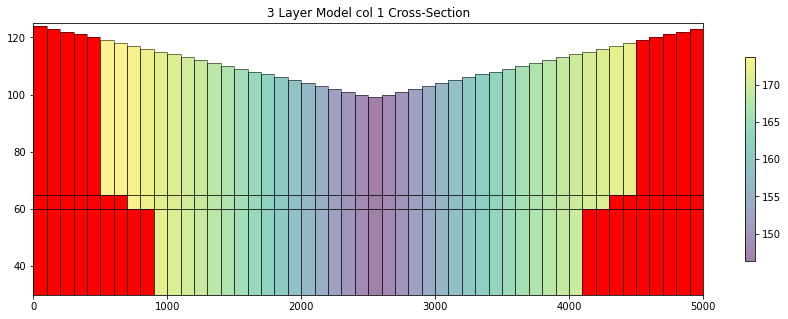

In [71]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 1}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 1 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])